In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

%matplotlib inline
from matplotlib import font_manager, rc

font_location = "C:\Windows\Fonts\malgun.ttf"
font_name = font_manager.FontProperties(fname=font_location).get_name()
rc('font', family=font_name)
plt.rcParams['axes.unicode_minus'] = False


In [3]:
import xml.etree.ElementTree as ET
import pandas as pd

def load_xml_to_df(file):
    tree = ET.parse(file)
    root = tree.getroot()

    rows = []
    for event in root.find("glucose_level").findall("event"):
        ts = event.attrib["ts"]
        value = event.attrib["value"]
        rows.append([ts, float(value)])

    return pd.DataFrame(rows, columns=["timestamp", "glucose"])


files = ["570-ws-training.xml", "563-ws-training.xml", "588-ws-training.xml"]
patients = [load_xml_to_df(f) for f in files]


for i, df in enumerate(patients):
    print(f"환자 {i+1} 데이터 크기:", df.shape)
    print(df.head(), "\n")


환자 1 데이터 크기: (10982, 2)
             timestamp  glucose
0  07-12-2021 16:29:00    101.0
1  07-12-2021 16:34:00    100.0
2  07-12-2021 16:39:00    100.0
3  07-12-2021 16:44:00     99.0
4  07-12-2021 16:49:00     98.0 

환자 2 데이터 크기: (12124, 2)
             timestamp  glucose
0  13-09-2021 12:33:00    219.0
1  13-09-2021 12:38:00    229.0
2  13-09-2021 12:43:00    224.0
3  13-09-2021 12:48:00    221.0
4  13-09-2021 12:53:00    215.0 

환자 3 데이터 크기: (12640, 2)
             timestamp  glucose
0  30-08-2021 11:53:00    116.0
1  30-08-2021 11:58:00    117.0
2  30-08-2021 12:03:00    119.0
3  30-08-2021 12:08:00    116.0
4  30-08-2021 12:13:00    111.0 



In [7]:
for i, df in enumerate(patients):
    df = df.resample("5min").mean().interpolate()
    patients[i] = df


In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


df["glucose"] = df["glucose"].interpolate(method="linear")
df["glucose"] = df["glucose"].fillna(method="ffill").fillna(method="bfill")

series = df["glucose"].values


recent_steps = 12  
future_step = 24     

def create_dataset(data, recent_steps, future_step):
    X, y = [], []
    for i in range(len(data) - recent_steps - future_step):
        X.append(data[i:i+recent_steps])
        y.append(data[i+recent_steps+future_step-1])
    return np.array(X), np.array(y)


scaler = MinMaxScaler()
series_scaled = scaler.fit_transform(series.reshape(-1,1)).flatten()

X, y = create_dataset(series_scaled, recent_steps, future_step)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test  = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


model = Sequential([
    LSTM(64, activation='tanh', input_shape=(recent_steps, 1)),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=20, batch_size=32,
                    validation_split=0.1, verbose=1)


y_pred = model.predict(X_test)


y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))
y_pred_inv = scaler.inverse_transform(y_pred)


C:\Users\OWNER\AppData\Local\Temp\ipykernel_19840\1837912997.py:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["glucose"] = df["glucose"].fillna(method="ffill").fillna(method="bfill")
C:\Users\OWNER\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0177 - val_loss: 0.0240
Epoch 2/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0153 - val_loss: 0.0173
Epoch 3/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0152 - val_loss: 0.0227
Epoch 4/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0151 - val_loss: 0.0168
Epoch 5/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0150 - val_loss: 0.0202
Epoch 6/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0148 - val_loss: 0.0180
Epoch 7/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0148 - val_loss: 0.0211
Epoch 8/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0147 - val_loss: 0.0196
Epoch 9/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0147 - val_loss: 0.0204
Epoch 10/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0147 - val_loss: 0.0225
Epoch 11/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0147 - val_loss: 0.0197
Epoch 12/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

LSTM 결과 → MAE: 29.77, RMSE: 39.64


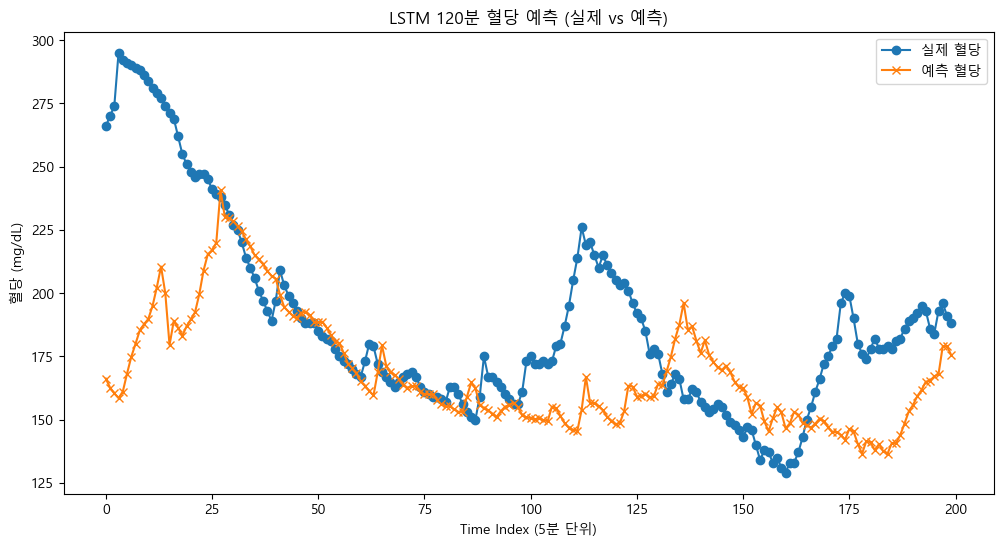

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np


mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))

print(f"LSTM 결과 → MAE: {mae:.2f}, RMSE: {rmse:.2f}")


plt.figure(figsize=(12,6))
plt.plot(y_test_inv[:200], label="실제 혈당", marker="o")   # 일부만 시각화 (200개 포인트)
plt.plot(y_pred_inv[:200], label="예측 혈당", marker="x")

plt.title("LSTM 120분 혈당 예측 (실제 vs 예측)")
plt.xlabel("Time Index (5분 단위)")
plt.ylabel("혈당 (mg/dL)")
plt.legend()
plt.show()


In [18]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


df_all = pd.concat(patients, ignore_index=True)


df_all["glucose"] = df_all["glucose"].interpolate(method="linear")
df_all["glucose"] = df_all["glucose"].fillna(method="ffill").fillna(method="bfill")

series = df_all["glucose"].values


recent_steps = 12    
future_step = 24     

def create_dataset(data, recent_steps, future_step):
    X, y = [], []
    for i in range(len(data) - recent_steps - future_step):
        X.append(data[i:i+recent_steps])
        y.append(data[i+recent_steps+future_step-1])
    return np.array(X), np.array(y)

scaler = MinMaxScaler()
series_scaled = scaler.fit_transform(series.reshape(-1,1)).flatten()

X, y = create_dataset(series_scaled, recent_steps, future_step)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test  = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


model = Sequential([
    LSTM(64, activation='tanh', input_shape=(recent_steps, 1)),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, y_train, epochs=20, batch_size=32,
                    validation_split=0.1, verbose=1)


y_pred = model.predict(X_test)


y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))
y_pred_inv = scaler.inverse_transform(y_pred)


C:\Users\OWNER\AppData\Local\Temp\ipykernel_19840\2152207641.py:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_all["glucose"] = df_all["glucose"].fillna(method="ffill").fillna(method="bfill")
C:\Users\OWNER\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
850/850 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0187 - val_loss: 0.0123
Epoch 2/20
850/850 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0163 - val_loss: 0.0134
Epoch 3/20
850/850 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0159 - val_loss: 0.0134
Epoch 4/20
850/850 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0158 - val_loss: 0.0129
Epoch 5/20
850/850 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0157 - val_loss: 0.0129
Epoch 6/20
850/850 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0154 - val_loss: 0.0131
Epoch 7/20
850/850 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0150 - val_loss: 0.0115
Epoch 8/20
850/850 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0149 - val_loss: 0.0116
Epoch 9/20
850/850 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0148 - val_loss: 0.0120
Epoch 10/20
850/850 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0148 - val_loss: 0.0135
Epoch 11/20
850/850 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0147 - val_loss: 0.0119
Epoch 12/20
850/850 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step

In [21]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input

results = []

recent_steps = 12
future_step = 24

def create_dataset(data, recent_steps, future_step):
    X, y = [], []
    for i in range(len(data) - recent_steps - future_step):
        X.append(data[i:i+recent_steps])
        y.append(data[i+recent_steps+future_step-1])
    return np.array(X), np.array(y)

for i in range(len(patients)):
    
    test_df = patients[i].copy()
    train_df = pd.concat([patients[j] for j in range(len(patients)) if j != i])

    
    train_df["glucose"] = train_df["glucose"].interpolate(method="linear").ffill().bfill()
    test_df["glucose"]  = test_df["glucose"].interpolate(method="linear").ffill().bfill()

    
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_df["glucose"].values.reshape(-1,1)).flatten()
    test_scaled  = scaler.transform(test_df["glucose"].values.reshape(-1,1)).flatten()

    
    X_train, y_train = create_dataset(train_scaled, recent_steps, future_step)
    X_test, y_test   = create_dataset(test_scaled, recent_steps, future_step)

    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test  = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    
    model = Sequential([
        Input(shape=(recent_steps, 1)),
        LSTM(64, activation='tanh'),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')

    model.fit(X_train, y_train, epochs=15, batch_size=32,
              validation_split=0.1, verbose=0)

    
    y_pred = model.predict(X_test)

    y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))
    y_pred_inv = scaler.inverse_transform(y_pred)

    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))  # squared=False 대신 직접 sqrt

    print(f"[환자 {i+1}] MAE: {mae:.2f}, RMSE: {rmse:.2f}")
    results.append({"환자": f"환자 {i+1}", "MAE": mae, "RMSE": rmse})


results_df = pd.DataFrame(results)
print("\n=== LOPO 결과 ===")
print(results_df)


362/362 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
[환자 1] MAE: 39.92, RMSE: 49.50
409/409 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
[환자 2] MAE: 33.07, RMSE: 42.78
409/409 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
[환자 3] MAE: 33.14, RMSE: 44.33

=== LOPO 결과 ===
     환자        MAE       RMSE
0  환자 1  39.923294  49.504829
1  환자 2  33.067625  42.779229
2  환자 3  33.140751  44.329873


In [22]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from sklearn.metrics import mean_absolute_error, mean_squared_error

recent_steps = 12
future_step = 24

def create_dataset(data, recent_steps, future_step):
    X, y = [], []
    for i in range(len(data) - recent_steps - future_step):
        X.append(data[i:i+recent_steps])
        y.append(data[i+recent_steps+future_step-1])
    return np.array(X), np.array(y)


df_all = pd.concat(patients, ignore_index=True)


df_all["glucose"] = df_all["glucose"].interpolate(method="linear").ffill().bfill()

series = df_all["glucose"].values



scaler = MinMaxScaler()
series_scaled = scaler.fit_transform(series.reshape(-1,1)).flatten()

X, y = create_dataset(series_scaled, recent_steps, future_step)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test  = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


model = Sequential([
    Input(shape=(recent_steps, 1)),
    LSTM(64, activation='tanh'),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, y_train, epochs=20, batch_size=32,
                    validation_split=0.1, verbose=1)


y_pred = model.predict(X_test)

y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))
y_pred_inv = scaler.inverse_transform(y_pred)

mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))

print("\n=== 전체 환자 통합 학습 결과 ===")
print(f"MAE : {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


Epoch 1/20
850/850 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0181 - val_loss: 0.0122
Epoch 2/20
850/850 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0162 - val_loss: 0.0124
Epoch 3/20
850/850 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0159 - val_loss: 0.0124
Epoch 4/20
850/850 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0157 - val_loss: 0.0118
Epoch 5/20
850/850 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0154 - val_loss: 0.0116
Epoch 6/20
850/850 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0150 - val_loss: 0.0121
Epoch 7/20
850/850 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0149 - val_loss: 0.0125
Epoch 8/20
850/850 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0148 - val_loss: 0.0118
Epoch 9/20
850/850 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0147 - val_loss: 0.0125
Epoch 10/20
850/850 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0146 - val_loss: 0.0117
Epoch 11/20
850/850 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0147 - val_loss: 0.0122
Epoch 12/20
850/850 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step

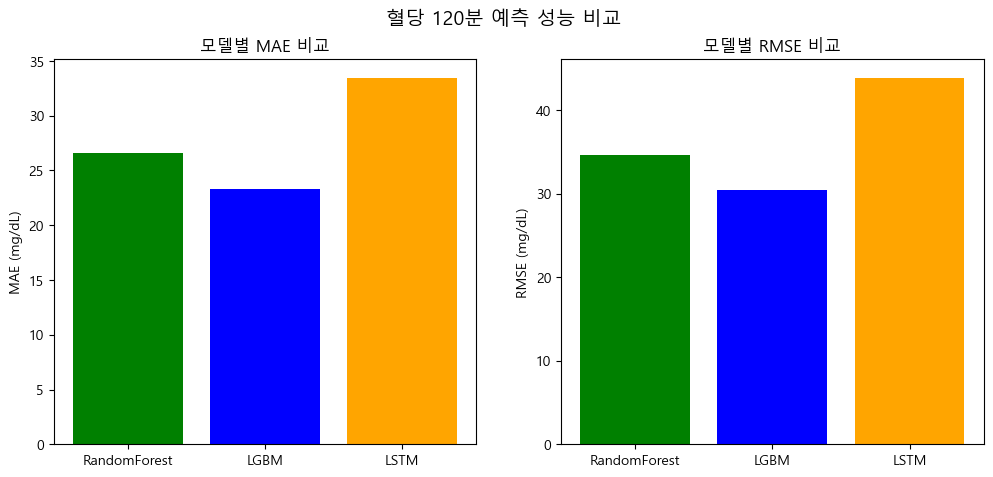

In [24]:
import matplotlib.pyplot as plt


mae_rf, rmse_rf   = 26.58, 34.61
mae_lgbm, rmse_lgbm = 23.27, 30.37
mae_lstm, rmse_lstm = 33.48, 43.87


models = ["RandomForest", "LGBM", "LSTM"]
mae_scores = [mae_rf, mae_lgbm, mae_lstm]
rmse_scores = [rmse_rf, rmse_lgbm, rmse_lstm]


fig, axes = plt.subplots(1, 2, figsize=(12, 5))


axes[0].bar(models, mae_scores, color=["green", "blue", "orange"])
axes[0].set_title("모델별 MAE 비교")
axes[0].set_ylabel("MAE (mg/dL)")


axes[1].bar(models, rmse_scores, color=["green", "blue", "orange"])
axes[1].set_title("모델별 RMSE 비교")
axes[1].set_ylabel("RMSE (mg/dL)")

plt.suptitle("혈당 120분 예측 성능 비교", fontsize=14)
plt.show()


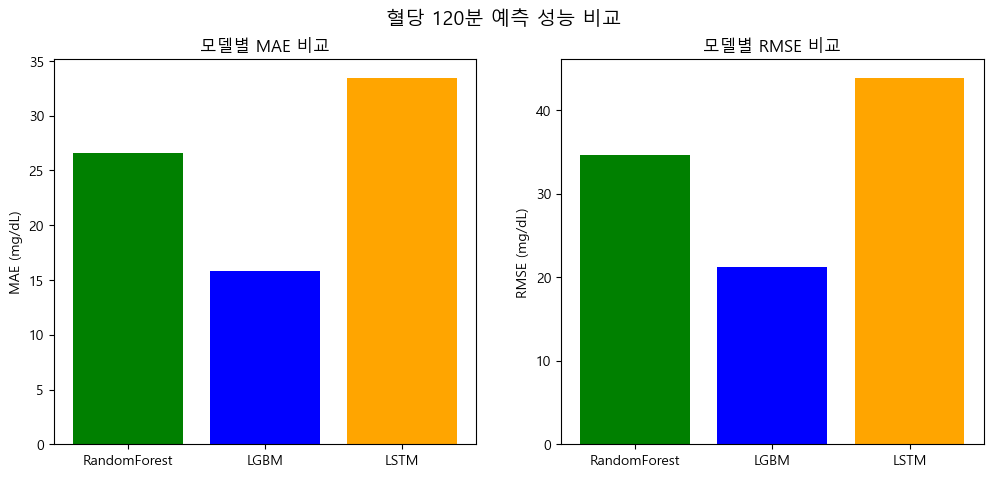

In [3]:
import matplotlib.pyplot as plt


mae_rf, rmse_rf   = 26.58, 34.61
mae_lgbm, rmse_lgbm = 15.82, 21.25
mae_lstm, rmse_lstm = 33.48, 43.87



models = ["RandomForest", "LGBM", "LSTM"]
mae_scores = [mae_rf, mae_lgbm, mae_lstm]
rmse_scores = [rmse_rf, rmse_lgbm, rmse_lstm]


fig, axes = plt.subplots(1, 2, figsize=(12, 5))


axes[0].bar(models, mae_scores, color=["green", "blue", "orange"])
axes[0].set_title("모델별 MAE 비교")
axes[0].set_ylabel("MAE (mg/dL)")


axes[1].bar(models, rmse_scores, color=["green", "blue", "orange"])
axes[1].set_title("모델별 RMSE 비교")
axes[1].set_ylabel("RMSE (mg/dL)")

plt.suptitle("혈당 120분 예측 성능 비교", fontsize=14)
plt.show()
